=== QAOA 결과 ===
최적 파라미터 (gammas, betas): [ 1.22659313  0.64371089 -0.66874066 -2.07596809 -0.68619166  2.60970587]
최소 기대값 (QUBO): 0.20265446362734651
가장 좋은 bitstring (QAOA 상태에서): 00
해당 bitstring의 QUBO 에너지: 0.0

QUBO exact 최소값: 0.0
해당 x (bitstring): (0, 0)


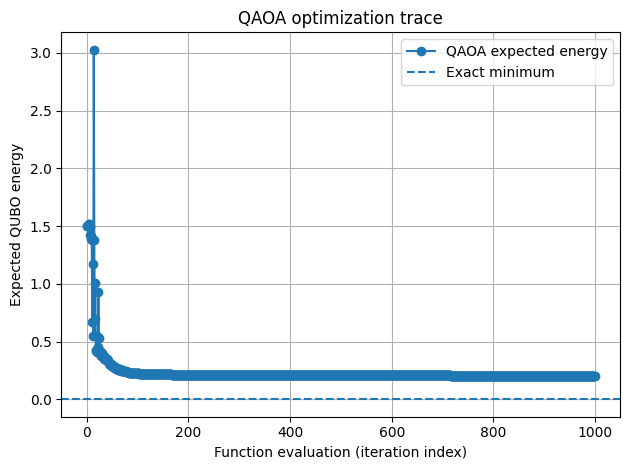

In [5]:
import numpy as np
import itertools
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# =========================
# 1. QUBO -> Ising 변환
# =========================

def qubo_to_ising(Q):
    """
    QUBO 행렬 Q (E(x) = x^T Q x, x_i in {0,1}) 를
    Ising 해밀토니안 H(z) = offset + sum_i h_i z_i + sum_{i<j} J_ij z_i z_j
    로 변환.

    x_i = (1 - z_i)/2, z_i in {-1, 1} 를 사용.
    """
    Q = np.array(Q, dtype=float)
    Q = 0.5 * (Q + Q.T)  # 대칭화

    n = Q.shape[0]
    h = np.zeros(n, dtype=float)
    J = np.zeros((n, n), dtype=float)
    offset = 0.0

    for i in range(n):
        offset += Q[i, i] / 2.0
        h[i]    += -Q[i, i] / 2.0

        for j in range(i + 1, n):
            offset += Q[i, j] / 4.0

            J[i, j] = Q[i, j] / 4.0
            J[j, i] = J[i, j]

            h[i] += -Q[i, j] / 4.0
            h[j] += -Q[i, j] / 4.0

    return h, J, offset


# =========================
# 2. Ising 해밀토니안으로 QAOA 회로 만들기
# =========================

def add_cost_unitary(qc, h, J, gamma):
    """
    비용 해밀토니안 H_C = sum_i h_i Z_i + sum_{i<j} J_ij Z_i Z_j
    에 대해 U_C(gamma) = exp(-i * gamma * H_C) 를 회로에 추가.
    """
    n = len(h)

    # 단일 Z_i 항
    for i in range(n):
        if abs(h[i]) > 1e-12:
            qc.rz(2 * gamma * h[i], i)

    # ZZ 상호작용 항
    for i in range(n):
        for j in range(i + 1, n):
            if abs(J[i, j]) > 1e-12:
                qc.cx(i, j)
                qc.rz(2 * gamma * J[i, j], j)
                qc.cx(i, j)


def add_mixer_unitary(qc, beta):
    """
    믹서 해밀토니안 H_M = sum_i X_i 에 대해
    U_M(beta) = exp(-i * beta * H_M) = ∏_i RX(2*beta)_i
    """
    n = qc.num_qubits
    for i in range(n):
        qc.rx(2 * beta, i)


def build_qaoa_circuit(h, J, gammas, betas):
    """
    주어진 (h, J)에 대해 p-layer QAOA 회로를 생성.

    초기 상태: |+>^{⊗ n}
    레이어 k:  U_C(gamma_k) -> U_M(beta_k)
    """
    n = len(h)
    p = len(gammas)
    assert p == len(betas), "gammas와 betas의 길이는 같아야 합니다."

    qc = QuantumCircuit(n)

    # 초기 상태 |+>^n
    for i in range(n):
        qc.h(i)

    # QAOA 레이어
    for layer in range(p):
        gamma = gammas[layer]
        beta = betas[layer]
        add_cost_unitary(qc, h, J, gamma)
        add_mixer_unitary(qc, beta)

    return qc


# =========================
# 3. 기대값 계산
# =========================

def qubo_energy_from_bitstring(bitstring, Q):
    """
    bitstring (예: '0101') 에 대해 QUBO 에너지 E(x) = x^T Q x 계산.
    Qiskit은 보통 little-endian이므로 bitstring[::-1] 로 맞춰줌.
    """
    x = np.array(list(map(int, bitstring[::-1])))  # 오른쪽이 x_0
    return float(x @ Q @ x)


def qaoa_expectation(params, Q, h, J):
    """
    주어진 파라미터 params = [gamma_1, ..., gamma_p, beta_1, ..., beta_p]
    에 대해 QAOA 상태의 QUBO 기대값 <E> 를 계산.
    """
    p = len(params) // 2
    gammas = params[:p]
    betas = params[p:]

    qc = build_qaoa_circuit(h, J, gammas, betas)

    sv = Statevector.from_label('0' * qc.num_qubits)
    sv = sv.evolve(qc)

    probs = sv.probabilities_dict()

    exp_val = 0.0
    for bitstring, prob in probs.items():
        e = qubo_energy_from_bitstring(bitstring, Q)
        exp_val += prob * e

    return exp_val


# =========================
# 4. QUBO의 exact minimum 계산 (brute force)
# =========================

def qubo_exact_min_energy(Q):
    """
    모든 bitstring x ∈ {0,1}^n 에 대해 x^T Q x 를 계산하여
    정확한 최소값을 반환.
    (n 이 너무 크면 지수적으로 느려지므로 작은 예제용)
    """
    Q = np.array(Q, dtype=float)
    n = Q.shape[0]

    best_E = None
    best_x = None
    for bits in itertools.product([0, 1], repeat=n):
        x = np.array(bits, dtype=float)
        E = float(x @ Q @ x)
        if (best_E is None) or (E < best_E):
            best_E = E
            best_x = bits

    return best_E, best_x


# =========================
# 5. 최적화 + 히스토리 기록
# =========================

def run_qaoa_with_history(Q, p=1, initial_params=None):
    """
    QUBO 행렬 Q 에 대해 p-layer QAOA 실행.
    SciPy minimize 로 기대값 최소화하면서
    각 objective 평가마다 (params, value)를 history에 기록.
    """
    Q = np.array(Q, dtype=float)
    n = Q.shape[0]
    h, J, offset = qubo_to_ising(Q)

    if initial_params is None:
        # [gamma_1, ..., gamma_p, beta_1, ..., beta_p]
        initial_params = 0.01 * np.random.randn(2 * p)

    history = {
        "values": [],   # objective 값들
        "params": []    # 그 때의 파라미터
    }

    # 목적 함수: 호출될 때마다 history에 기록
    def objective(params):
        val = qaoa_expectation(params, Q, h, J)
        history["values"].append(val)
        history["params"].append(np.array(params, dtype=float))
        return val

    opt = minimize(objective, initial_params, method='COBYLA')
    # opt = minimize(objective, initial_params, method='Nelder-Mead')
    # opt = minimize(objective, initial_params, method='Powell')


    opt_params = opt.x
    min_value = opt.fun

    # 최적 파라미터로 상태를 만들어서 bitstring 분포 확인
    gammas = opt_params[:p]
    betas = opt_params[p:]
    qc_opt = build_qaoa_circuit(h, J, gammas, betas)
    sv_opt = Statevector.from_label('0' * n).evolve(qc_opt)
    probs = sv_opt.probabilities_dict()

    best_bitstring = None
    best_energy = None
    for bitstring, prob in probs.items():
        if prob < 1e-6:
            continue
        e = qubo_energy_from_bitstring(bitstring, Q)
        if (best_energy is None) or (e < best_energy):
            best_energy = e
            best_bitstring = bitstring

    return {
        "opt_params": opt_params,
        "min_value": min_value,
        "best_bitstring": best_bitstring,
        "best_energy": best_energy,
        "offset": offset,
        "h": h,
        "J": J,
        "history": history,
    }


# =========================
# 6. 예시 + 그래프 그리기 (exact 값 점선)
# =========================

if __name__ == "__main__":
    # 예시 QUBO (2-qubit)
    Q = np.array([
        [1.0, -2.0],
        [-2.0, 4.0]
    ])

    p = 3  # QAOA layer 수

    # QAOA 최적화
    result = run_qaoa_with_history(Q, p=p)

    print("=== QAOA 결과 ===")
    print("최적 파라미터 (gammas, betas):", result["opt_params"])
    print("최소 기대값 (QUBO):", result["min_value"])
    print("가장 좋은 bitstring (QAOA 상태에서):", result["best_bitstring"])
    print("해당 bitstring의 QUBO 에너지:", result["best_energy"])

    # QUBO exact 최소값 계산
    exact_min, exact_x = qubo_exact_min_energy(Q)
    print("\nQUBO exact 최소값:", exact_min)
    print("해당 x (bitstring):", exact_x)

    # 히스토리 꺼내기
    values = result["history"]["values"]
    iters = np.arange(len(values))

    # --------- 최적화 과정 그래프 ---------
    plt.figure()
    plt.plot(iters, values, marker='o', label="QAOA expected energy")

    # exact minimum 수평 점선
    plt.axhline(exact_min, linestyle="--", label="Exact minimum")

    plt.xlabel("Function evaluation (iteration index)")
    plt.ylabel("Expected QUBO energy")
    plt.title("QAOA optimization trace")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()